In [1]:
from multisensory_playbook import (
    ClassicalTask,
    DetectionTask,
    DetectionTask_versatile,
    LinearClassifier,
    Trials
)

import pickle
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from scipy.optimize import fsolve
import joblib
import sys, os
from pylab import *



In [2]:
def calculate_pg(ff, k, N=90, correction=1):
    """
    Use ff to calulate pg, given a k and N
    ff: desired filtered fraction of E 
    pg: probability of E(t)=1 in the base_e (generator)
    k : local on-time duration
    N : number time-steps
    """
    buffer = k
    #pg = (1-fsolve(lambda x: ff-(1-x**k)/(1-x**(N)), 0.9))[0] 
    if correction:
        ff = (1-fsolve(lambda x: ff-(1-x**k)/(1-x**(N+int(buffer)-1*(k-1))), 0.9))[0]

    return ff

def levy_solve_for_pg(ff_desired, pl, N=500): 
    cpl=cumsum(pl) 

    lmax = len(pl)-1 
    
    lengths = arange(lmax+1) 
    
    fs = lambda pg: 1-prod(1-pg+pg*cpl) 
    
    ff = lambda pg: fs(pg)/(1-prod((1-pg*pl[1:])**(N+lengths[1:]-1))) 
    
    pg = fsolve(lambda pg: ff_desired-ff(pg), ff_desired)[0] 
    
    return pg 


def levy_dist(lmax):
  l = arange(lmax+1) # allow l=0 but must have p=0
  pl = zeros(lmax+1)
  pl[1:] = 1.0/l[1:]**2
  pl[:] /= sum(pl)
  return pl
    
def generate_mix_samples(pg, pl, N=90, repeats=10):
  
  lmax = len(pl)-1
  #print('lmax ', lmax)
  #pgl = pg*pl
  M = N+lmax-1
  all_E = []
  positions = arange(M)
  lengths = arange(lmax+1)
  for _ in range(repeats):
    keep_going = True
    while keep_going:
      # generate nonzero points
      num_nonzero = binomial(M, pg)
      if num_nonzero==0:
        continue
      E_starts = choice(positions, size=num_nonzero, replace=False)
      L = choice(lengths, size=num_nonzero, p=pl)
      #print('L ', L)
      E = zeros(M, dtype=bool)
      for e_start, l in zip(E_starts, L):
        E[e_start:e_start+l] = 1
      E = E[lmax-1:]
      assert len(E)==N
      keep_going = (sum(E)==0)
    all_E.append(E)
  all_E = array(all_E) # shape (repeats, N)
  return all_E

def estimate_fraction_on(pg, pl, N=90, repeats=1000):
  return generate_mix_samples(pg, pl, N=N, repeats=repeats).mean()

def generate_levy_AV(pm, pn, pi, pc, nb_trials, nb_steps, E):
    arr_M = choice([-1, 0, 1], size=nb_trials, p=[pm / 2, 1 - pm, pm / 2])
    arr_A = np.zeros((nb_trials, nb_steps), dtype=int) # Q1! + k padding in the begining of E for Levy flights?
    arr_V = np.zeros((nb_trials, nb_steps), dtype=int)
    arr_E = E #np.zeros((nb_trials, nb_steps-k), dtype=int)

    for trial in range(nb_trials):
        M = arr_M[trial]
        e0 = np.array([-1, 0, 1]) # Add noise if E = 0
        p_e0 = np.array([pn / 2, 1 - pn, pn / 2])
        e1 = np.array([-M, 0, M]) # add probabilities for incorrectness
        p_e1 = np.array([pi, 1 + (- pc - pi), pc])
        
        A = np.where(E[trial], choice(e1, size=E[trial].size, p=p_e1), choice(e0, size=E[trial].size, p=p_e0))
        V = np.where(E[trial], choice(e1, size=E[trial].size, p=p_e1), choice(e0, size=E[trial].size, p=p_e0))
        arr_A[trial, :] = A 
        arr_V[trial, :] = V
        #arr_E[trial, :] = E[trial]
            
    return arr_M, arr_A, arr_V,arr_E

In [3]:
k_list = [1,2,3,4,5,6,7,8]
windowsize_list = [2,3]

pe_sparse = 0.04

time_dep = 1 # 1: there is time dependence



lmax = 8 #levy k max
pl = levy_dist(lmax) # #8 * [1/8] #
pm, pn, pi, pc, nb_trials, nb_steps = 1, 1/3, 0.01, 0.45, 100000, 500
E = generate_mix_samples(pg=levy_solve_for_pg(pe_sparse, pl, N=500), pl=pl, N=nb_steps, repeats=nb_trials)

# Generate testing data 
training_size = nb_trials
M, A, V, E = generate_levy_AV(pm, pn, pi, pc, nb_trials, nb_steps, E)
testing_trials = Trials(
    repeats=training_size,
    time_steps=nb_steps+lmax-1,
    M=M,
    A=A,
    V=V,
    task=None
)

In [4]:
def plot_avE(E):
    # Calculate mean (which is equivalent to probability for binary data)
    avE = np.mean(E, axis=0)

    # Calculate standard deviation for binary data
    stdE = np.sqrt(avE * (1 - avE))

    plt.figure(figsize=(12, 3))
    plt.plot(avE, label='Mean/Probability', color='steelblue')
    plt.fill_between(range(len(avE)), avE - stdE, avE + stdE, alpha=0.3, color='lightblue', label='±1 SD')
    plt.title(f" x̄ = {np.round(np.mean(avE),2)}")
    plt.ylabel('Probability')
    plt.xlabel('Time Step')
    plt.legend()
    #plt.ylim(0, 0.6)  # Set y-axis limits to 0-1 for probability
    plt.show()

    # Print some statistics
    print(f"Min probability: {np.min(avE):.4f}")
    print(f"Max probability: {np.max(avE):.4f}")
    print(f"Overall mean probability: {np.mean(avE):.4f}")

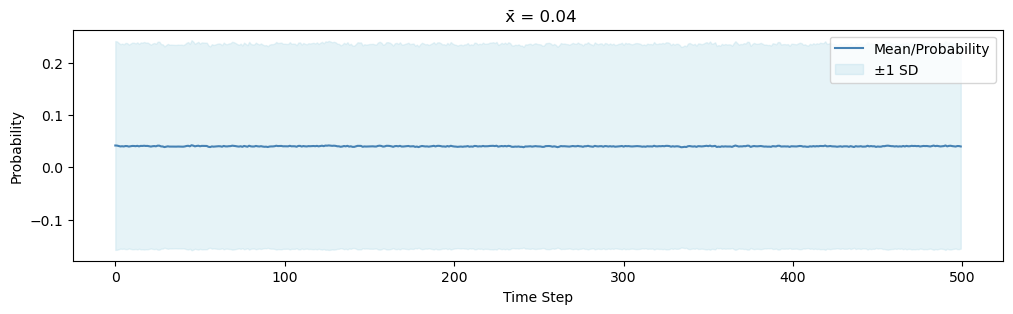

Min probability: 0.0382
Max probability: 0.0421
Overall mean probability: 0.0400


In [7]:
plot_avE(E)

In [8]:
#file_path = f'./trainedclassifier/NLFw_trained_classifiers_500steps.pkl'
file_path = f'./NLFw_trained_classifiers_500steps_Levy_eq.pkl' # NLFw_trained_classifiers_500steps_Levy

with open(file_path, 'rb') as file:
    trained_classifiers_dict = pickle.load(file)

In [9]:
trained_classifiers_dict

{('levy', 2): <multisensory_playbook.LinearClassifier at 0x7f7e0be6f440>,
 ('levy', 3): <multisensory_playbook.LinearClassifier at 0x7f7d45665b20>}

In [10]:
prefix_list = ['LF', 'NLF_1']
k_list = ['levy']

In [11]:
for pairs in [2]:
    if pairs == 2:
        windowsize_list = [2,3]
    if pairs in [0,1]:
        windowsize_list = prefix_list # Rename windowsize for saving in dictionary
    acc_dict = {}
    metrics_dict = {}
    for train_k in k_list:
        for windowsize in windowsize_list:
            trained_classifier = trained_classifiers_dict[(train_k, windowsize)]       
            E = generate_mix_samples(pg=levy_solve_for_pg(pe_sparse, pl, N=nb_steps), pl=pl, N=nb_steps, repeats=nb_trials)

            # Generate testing data 
            training_size = nb_trials
            M, A, V, E = generate_levy_AV(pm, pn, pi, pc, nb_trials, nb_steps, E)
            testing_trials = Trials(
                repeats=training_size,
                time_steps=nb_steps+lmax-1,
                M=M,
                A=A,
                V=V,
                task=None
            )
            # Calculate accuracy
    
            classifier = trained_classifier
            res = classifier.test(testing_trials)
            accs = res.accuracy
            if pairs in [0,1]:
                windowsize = prefix_list[pairs] # Rename windowsize for saving in dictionary         
            acc_dict[(train_k,windowsize,'Levy')] = accs
            metrics_dict[(train_k, windowsize, 'Levy')] = {
                'accuracy': res.accuracy,
                'precision': res.precision.tolist(),  # Convert numpy array to list for easier storage
                'recall': res.recall.tolist(),
                'f1': res.f1.tolist(),
                'support': res.support.tolist(),
                'class_distribution': res.class_distribution.tolist()
            }
    
    if pairs in [0,1]:
        with open(f'./{prefix_list[pairs]}_classifier_testmetrics_onlevy_eq.pkl', 'wb') as file:
          pickle.dump(pickle.dump(metrics_dict, file), file)
    else:
        with open('./NLFw_classifier_testmetrics_testedonlevy_trainedonlevy_eq.pkl', 'wb') as file:
          pickle.dump(metrics_dict, file)

win size:  2
win size:  3


In [12]:
acc_dict 

{('levy', 2, 'Levy'): 0.828, ('levy', 3, 'Levy'): 0.823}

In [11]:
# Repeating
k_list = [1,2,3,4,5,6,7,8]
windowsize_list = [2,3]

pe_sparse = 0.04

time_dep = 1 # 1: there is time dependence



lmax = 8 #levy k max
pl = levy_dist(lmax) # #
pm, pn, pi, pc, nb_trials, nb_steps = 1, 1/3, 0.01, 0.45, 100000, 500
E = generate_mix_samples(pg=levy_solve_for_pg(pe_sparse, pl, N=500), pl=pl, N=nb_steps, repeats=nb_trials)

# Generate testing data 
training_size = nb_trials
M, A, V, E = generate_levy_AV(pm, pn, pi, pc, nb_trials, nb_steps, E)
testing_trials = Trials(
    repeats=training_size,
    time_steps=nb_steps+lmax-1,
    M=M,
    A=A,
    V=V,
    task=None
)

for pairs in [2]:
    if pairs == 2:
        windowsize_list = [2,3]
    if pairs in [0,1]:
        windowsize_list = prefix_list # Rename windowsize for saving in dictionary
    acc_dict = {}
    metrics_dict = {}
    for train_k in k_list:
        for windowsize in windowsize_list:
            trained_classifier = trained_classifiers_dict[(train_k, windowsize)]       
            E = generate_mix_samples(pg=levy_solve_for_pg(pe_sparse, pl, N=nb_steps), pl=pl, N=nb_steps, repeats=nb_trials)

            # Generate testing data 
            training_size = nb_trials
            M, A, V, E = generate_levy_AV(pm, pn, pi, pc, nb_trials, nb_steps, E)
            testing_trials = Trials(
                repeats=training_size,
                time_steps=nb_steps+lmax-1,
                M=M,
                A=A,
                V=V,
                task=None
            )
            # Calculate accuracy
    
            classifier = trained_classifier
            res = classifier.test(testing_trials)
            accs = res.accuracy
            if pairs in [0,1]:
                windowsize = prefix_list[pairs] # Rename windowsize for saving in dictionary         
            acc_dict[(train_k,windowsize,'Levy')] = accs
            metrics_dict[(train_k, windowsize, 'Levy')] = {
                'accuracy': res.accuracy,
                'precision': res.precision.tolist(),  # Convert numpy array to list for easier storage
                'recall': res.recall.tolist(),
                'f1': res.f1.tolist(),
                'support': res.support.tolist(),
                'class_distribution': res.class_distribution.tolist()
            }
    
    if pairs in [0,1]:
        with open(f'./{prefix_list[pairs]}_classifier_testmetrics_onlevy_eq.pkl', 'wb') as file:
          pickle.dump(pickle.dump(metrics_dict, file), file)
    else:
        with open('./NLFw_classifier_testmetrics_testedonlevy.pkl', 'wb') as file:
          pickle.dump(metrics_dict, file)

win size:  2
win size:  3
win size:  2
win size:  3
win size:  2
win size:  3
win size:  2
win size:  3
win size:  2
win size:  3
win size:  2
win size:  3
win size:  2
win size:  3
win size:  2
win size:  3


In [47]:
acc_dict # flat

{(1, 2, 'Levy'): 0.995,
 (1, 3, 'Levy'): 0.995,
 (2, 2, 'Levy'): 0.996,
 (2, 3, 'Levy'): 0.996,
 (3, 2, 'Levy'): 0.996,
 (3, 3, 'Levy'): 0.997,
 (4, 2, 'Levy'): 0.996,
 (4, 3, 'Levy'): 0.997,
 (5, 2, 'Levy'): 0.996,
 (5, 3, 'Levy'): 0.997,
 (6, 2, 'Levy'): 0.996,
 (6, 3, 'Levy'): 0.996,
 (7, 2, 'Levy'): 0.996,
 (7, 3, 'Levy'): 0.997,
 (8, 2, 'Levy'): 0.996,
 (8, 3, 'Levy'): 0.997}

In [12]:
acc_dict # flat and trained on Levy

{(1, 2, 'Levy'): 0.826,
 (1, 3, 'Levy'): 0.824,
 (2, 2, 'Levy'): 0.832,
 (2, 3, 'Levy'): 0.831,
 (3, 2, 'Levy'): 0.831,
 (3, 3, 'Levy'): 0.832,
 (4, 2, 'Levy'): 0.828,
 (4, 3, 'Levy'): 0.824,
 (5, 2, 'Levy'): 0.828,
 (5, 3, 'Levy'): 0.822,
 (6, 2, 'Levy'): 0.825,
 (6, 3, 'Levy'): 0.819,
 (7, 2, 'Levy'): 0.825,
 (7, 3, 'Levy'): 0.818,
 (8, 2, 'Levy'): 0.823,
 (8, 3, 'Levy'): 0.817}

In [68]:
acc_dict

{('levy', 2, 'Levy'): 0.947, ('levy', 3, 'Levy'): 0.946}